In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [28]:
# Find the Bezier curve basis functions
#
# They're 4 polynomials of order 3 which at t=0,1/3,2/3,1 phi_i(t_j)=kronecker(i,j)
ts = np.array([0, 1/3, 2/3, 1])

T=np.stack([ts**0, ts**1, ts**2, ts**3])
invT = np.linalg.inv(T)
print(invT)

def phi0(x):
    return invT[0,0] + invT[0,1]*x +invT[0,2]*(x**2)+invT[0,3]*(x**3)
def phi1(x):
    return invT[1,0] + invT[1,1]*x +invT[1,2]*(x**2)+invT[1,3]*(x**3)
def phi2(x):
    return invT[2,0] + invT[2,1]*x +invT[2,2]*(x**2)+invT[2,3]*(x**3)
def phi3(x):
    return invT[3,0] + invT[3,1]*x +invT[3,2]*(x**2)+invT[3,3]*(x**3)


[[  1.   -5.5   9.   -4.5]
 [  0.    9.  -22.5  13.5]
 [  0.   -4.5  18.  -13.5]
 [  0.    1.   -4.5   4.5]]


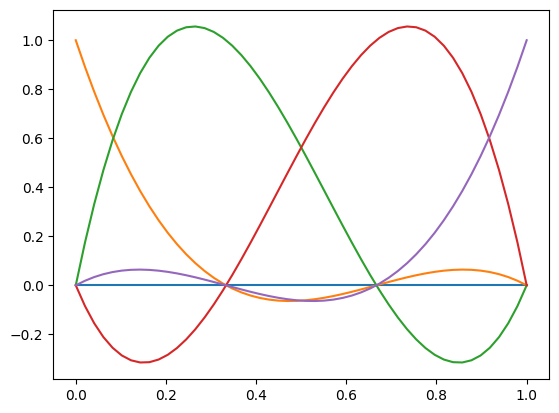

In [30]:
plt.plot([0,1], [0,0])
plt.plot(np.linspace(0,1), phi0(np.linspace(0,1)))
plt.plot(np.linspace(0,1), phi1(np.linspace(0,1)))
plt.plot(np.linspace(0,1), phi2(np.linspace(0,1)))
plt.plot(np.linspace(0,1), phi3(np.linspace(0,1)))

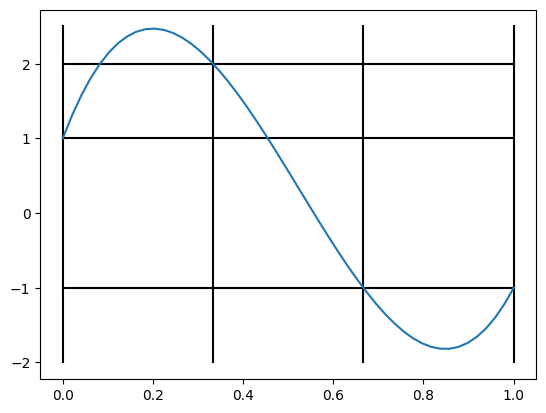

In [36]:
t = np.linspace(0,1)
plt.plot([0,1],[1,1],'k')
plt.plot([0,1],[2,2],'k')
plt.plot([0,1],[-1,-1],'k')
plt.plot([0,0],[-2,2.5],'k')
plt.plot([1/3,1/3],[-2,2.5],'k')
plt.plot([2/3,2/3],[-2,2.5],'k')
plt.plot([1,1],[-2,2.5],'k')


plt.plot(t, 1.0*phi0(t) + 2.0*phi1(t)+ -1.0*phi2(t) + -1.0*phi3(t))

Now inverting for the spline coefficients if we're given $(x,t)$ pairs.
by minimizing $e = \sum_i (\sum_j a_j \phi_j(t_i) - x_i)^2$  wrt the $a_j$s.

We can write this using $\Delta_i= \sum_j a_j \phi_j(t_i)-x_i$ which gives

$$
e = \sum_i \Delta_i^2
$$

then

$$
\begin{align}
\frac{\partial e}{\partial a_k} &= 2 \sum_i \Delta_i \cdot \frac{\partial}{\partial a_k} \Delta_i \\
&= 2 \sum_i \Delta_i \cdot \phi_k(t_i) \\
&= 2 \sum_i (\sum_j a_j \phi_j(t_i)-x_i)\cdot \phi_k(t_i)
\end{align}
$$

At the minima these must be zero, so after rearanging we get

$$
\begin{align}
\sum_{i, j} a_j \phi_j(t_i)\cdot\phi_k(t_i) &= \sum_i \phi_k(t_i)\cdot x_i \\
[\Phi\Phi][a] &= [\Phi X] \\
[a] = [\Phi\Phi]^{-1}[\Phi X]
\end{align}
$$

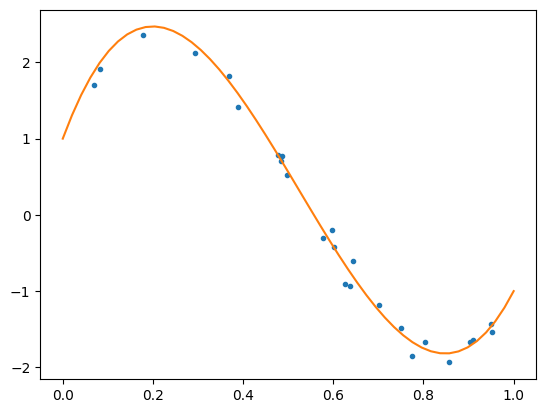

In [42]:
def f(tt):
    return 1.0*phi0(tt) + 2.0*phi1(tt)+ -1.0*phi2(tt) + -1.0*phi3(tt)
tt = np.random.random(25)

xx = f(tt) + np.random.randn(25)*0.125
plt.plot(tt,xx,'.')
plt.plot(t,f(t))

In [52]:
P = np.stack( [phi0(tt), phi1(tt), phi2(tt), phi3(tt)])
PX = np.matmul(P, xx)
PP = np.matmul(P, P.T)
a = np.matmul(np.linalg.inv(PP), PX)
print(a)
def fa(t):
    return a[0]*phi0(t)+a[1]*phi1(t)+a[2]*phi2(t)+a[3]*phi3(t)

[ 0.82104671  1.94996869 -1.00617329 -1.01568732]


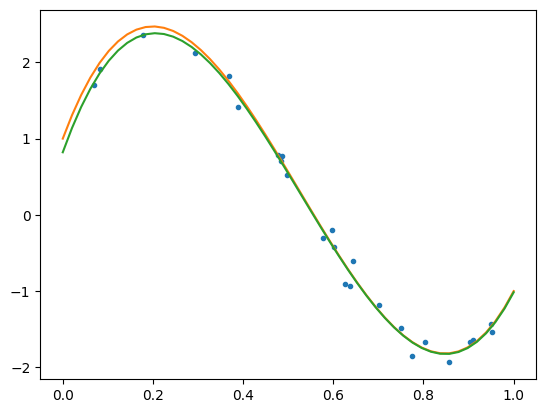

In [53]:
plt.plot(tt,xx,'.')
plt.plot(t,f(t))
plt.plot(t,fa(t))

This works in N dimensions too. And everything decouples nicely so we endup solving N 4x4 systems, not a 4Nx4N system.

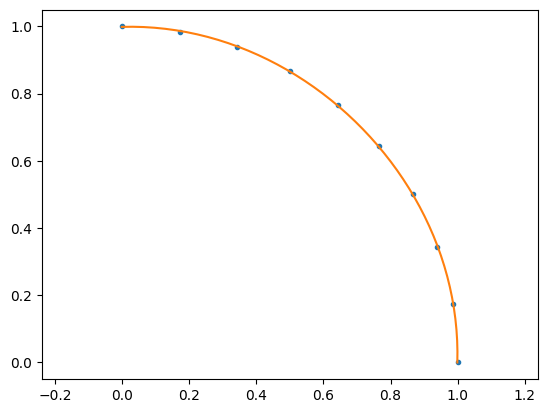

In [62]:
t=np.linspace(0,1,10)
x=np.cos(t*np.pi/2)
y=np.sin(t*np.pi/2)
plt.plot(x,y,'.')
plt.axis('equal')

P = np.stack( [phi0(t), phi1(t), phi2(t), phi3(t)])
PX = np.matmul(P, x)
PY = np.matmul(P, y)
PP = np.matmul(P, P.T)

ax = np.matmul(np.linalg.inv(PP), PX)
ay = np.matmul(np.linalg.inv(PP), PY)

def fax(t):
    return ax[0]*phi0(t)+ax[1]*phi1(t)+ax[2]*phi2(t)+ax[3]*phi3(t)

def fay(t):
    return ay[0]*phi0(t)+ay[1]*phi1(t)+ay[2]*phi2(t)+ay[3]*phi3(t)

z=np.linspace(0,1)
plt.plot(fax(z),fay(z))


Another consideration is that we might know the end points exactly - how does that change our derivation?
We'll end up with 2x2 systems to solve - but what are they?

Also if we're in N dimensions we might only know the point locations, but not the t values. And we need to deduce them.
This is not easy - and is infact ill posed without start-end points.

The problem changes from resulting in a linear system that we can solve exactly, to a nonlinear one.
And the best way to solve it is unclear.

We now have two sets of unknowns, the $a_j$ and the $t_i$. 

Since the system is nonlinear we could reach directly for a gradient style minimisation of $e$ wrt the combined parameter set.

But for a given $t_i$ the equations are solvable directly - so that might give us a better hybrid approach.

